In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.8'

print(os.environ['XLA_FLAGS'])

import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
sns.set(style = 'ticks', color_codes = True)
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint

--xla_gpu_cuda_data_dir=/usr/local/cuda-11.8


2023-09-27 18:42:21.078957: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 18:42:21.117252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
processed = pd.read_pickle("objects/processed.pkl")
processed

2023-09-27 18:42:23.083292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 18:42:23.106760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 18:42:23.106843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


,Processed Input,Real Input,Label
0,"(The, iPad, screen, is, frozen, in, landscape,...",The iPad screen is frozen in landscape or port...,Others
1,"(OneDrive, not, syncing, files, or, folders)",OneDrive not syncing files or folders.,Others
2,"(Keyboard, backlight, not, working, as, expected)",Keyboard backlight not working as expected.,Others
3,"(My, Apple, Pencil, is, n't, responding)",My Apple Pencil isn't responding.,Others
4,"(Can, I, request, a, 3, day, medical, certific...",Can I request a 3-day medical certificate star...,MC
...,...,...,...
637,"(Hey, I, 'm, taking, a, sick, day, from, schoo...","Hey, I'm taking a sick day from school because...",Others
638,"(Right, click, context, menu, not, appearing, ...",Right-click context menu not appearing when ta...,Others
639,"(My, Apple, Pencil, is, not, in, working, cond...",My Apple Pencil is not in working condition.,Others
640,"(Software, update, needed, to, fix, internet, ...",Software update needed to fix internet connect...,Others


In [3]:
processed_input = [doc.text for doc in processed["Processed Input"]]

input_len = 150

tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_input)

def convert_to_padded(sequences):
    padded_sequences = pad_sequences(tokenizer.texts_to_sequences(sequences), input_len)
    return padded_sequences

sequences = convert_to_padded(processed_input)

tokenizer.index_word


{1: 'i',
 2: 'a',
 3: 'to',
 4: 'the',
 5: 'not',
 6: 'day',
 7: 'my',
 8: 'be',
 9: 'on',
 10: 'or',
 11: "n't",
 12: 'and',
 13: 'in',
 14: 'mc',
 15: 'laptop',
 16: 'today',
 17: 'is',
 18: 'screen',
 19: 'need',
 20: 'with',
 21: 'from',
 22: 'wo',
 23: 'of',
 24: 'school',
 25: 'hi',
 26: 'ipad',
 27: 'so',
 28: 'due',
 29: 'working',
 30: "'s",
 31: "'m",
 32: 'work',
 33: 'doctor',
 34: 'have',
 35: 'medical',
 36: 'for',
 37: 'at',
 38: 'after',
 39: 'mouse',
 40: 'because',
 41: 'apple',
 42: 'keyboard',
 43: 'pencil',
 44: 'onedrive',
 45: 'wi',
 46: 'fi',
 47: "'ll",
 48: 'touchpad',
 49: 'appointment',
 50: 'ca',
 51: 'system',
 52: 'when',
 53: 'severe',
 54: 'frozen',
 55: 'bluetooth',
 56: 'during',
 57: '3',
 58: 'it',
 59: 'as',
 60: 'an',
 61: 'specific',
 62: 'starting',
 63: 'app',
 64: 'speakers',
 65: 'there',
 66: 'must',
 67: 'issues',
 68: 'internet',
 69: 'feeling',
 70: 'hello',
 71: 'google',
 72: 'come',
 73: 'hey',
 74: 'certificate',
 75: 'classroom',
 76

In [4]:
vocab_size = len(tokenizer.word_counts) + 1
vocab_size

1200

In [5]:
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()

X = np.array(sequences)
processed['encoded_labels'] = label_encoder.fit_transform(processed['Label'])

y = to_categorical(processed['encoded_labels'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shapes:\nX_train: {X_train.shape}, y_train: {y_train.shape}\nX_test: {X_test.shape}, y_test: {y_test.shape}")

label_encoder.classes_

Shapes:
X_train: (513, 150), y_train: (513, 3)
X_test: (129, 150), y_test: (129, 3)


array(['MC', 'Non MC', 'Others'], dtype=object)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

def create_model(vocab_size, input_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=input_len)) # turn +ve ints into dense vectors [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
    model.add(Bidirectional(LSTM(50)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = "softmax"))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

model = create_model(vocab_size=vocab_size, input_len=input_len)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           60000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              40400     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                      

2023-09-27 18:43:16.803189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-27 18:43:16.804727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-27 18:43:16.805815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [10]:
filename = 'models/intent_classification.h5'

# Learning rate scheduling
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_sched_checkpoint = tf.keras.callbacks.LearningRateScheduler(scheduler)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# save the best model
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# fit model with all callbacks above
hist = model.fit(X_train, y_train, epochs = 20, batch_size=10, validation_data=(X_test, y_test), callbacks=[checkpoint, lr_sched_checkpoint, early_stopping])

Epoch 1/20


2023-09-27 18:43:17.702874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-27 18:43:17.705054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-27 18:43:17.707110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

52/52 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.6413

2023-09-27 18:43:30.422579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-27 18:43:30.424792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-27 18:43:30.429132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.72660, saving model to models/intent_classification.h5
52/52 [==============================] - 14s 151ms/step - loss: 0.9687 - accuracy: 0.6413 - val_loss: 0.7266 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 2/20
51/52 [============================>.] - ETA: 0s - loss: 0.7487 - accuracy: 0.7529
Epoch 2: val_loss improved from 0.72660 to 0.42463, saving model to models/intent_classification.h5
52/52 [==============================] - 3s 60ms/step - loss: 0.7473 - accuracy: 0.7544 - val_loss: 0.4246 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.8285
Epoch 3: val_loss improved from 0.42463 to 0.32729, saving model to models/intent_classification.h5
52/52 [==============================] - 3s 56ms/step - loss: 0.5726 - accuracy: 0.8285 - val_loss: 0.3273 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 0.4890 - accurac

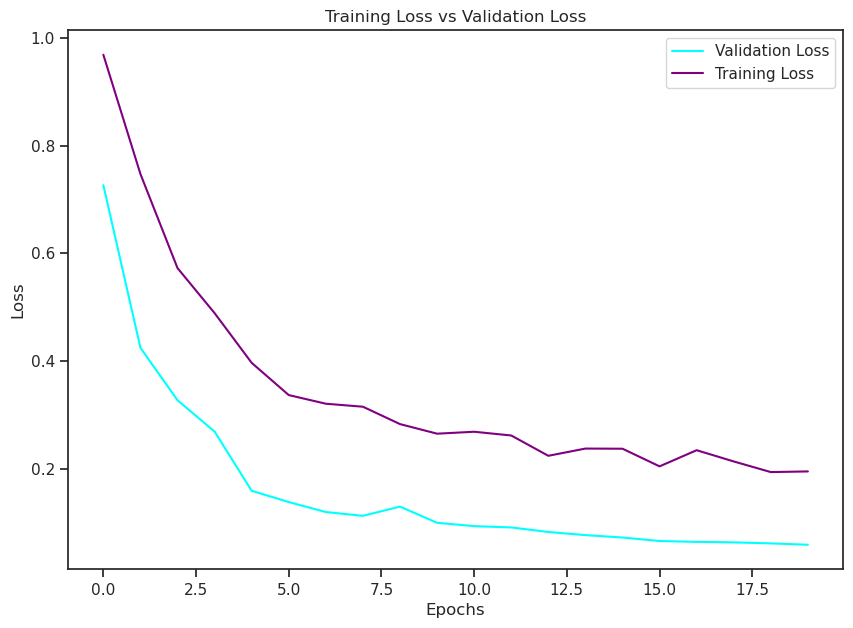

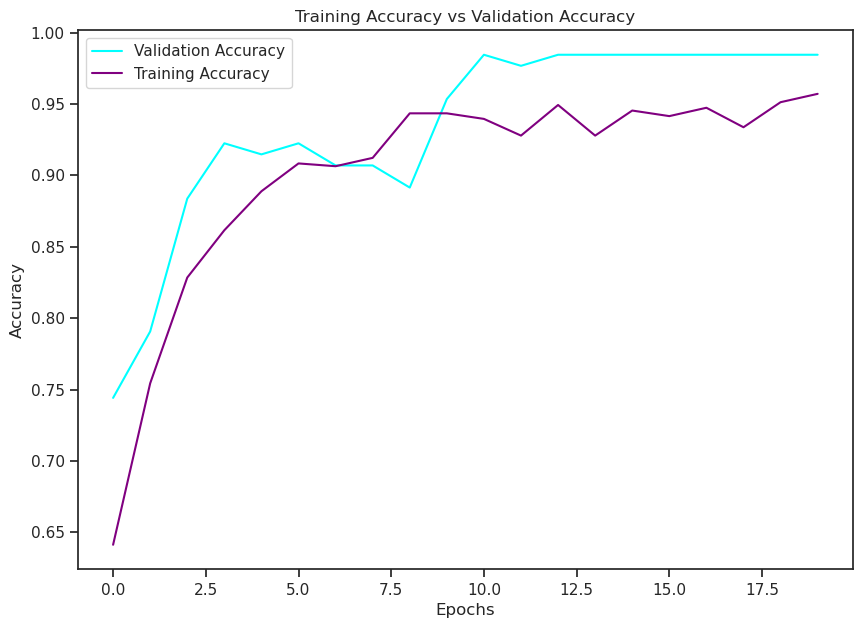

In [11]:
# Visualizing Training Loss vs Validation Loss (the loss is how wrong your model is)
plt.figure(figsize=(10,7))
plt.plot(hist.history['val_loss'], label = 'Validation Loss', color = 'cyan')
plt.plot(hist.history['loss'], label = 'Training Loss', color = 'purple')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualizing Testing Accuracy vs Validation Accuracy
plt.figure(figsize=(10,7))
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy', color = 'cyan')
plt.plot(hist.history['accuracy'], label = 'Training Accuracy', color = 'purple')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
from keras.models import load_model
model = load_model('models/intent_classification.h5')

# predicted_classes = model.predict(X_test).argmax(axis = -1)

# confusion_matrix(y_test.argmax(axis=1), predicted_classes)

# print(classification_report(y_test.argmax(axis=1),predicted_classes))

2023-09-27 18:44:28.055345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-27 18:44:28.057854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-27 18:44:28.059080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
def infer_intent(user_input):
    '''receive user input and output dictionary of predictions'''
    assert isinstance(user_input, str)
    user_input = [user_input]
    print(user_input)

    padded_input = convert_to_padded(user_input)

    # Prediction for each document
    probs = model.predict(padded_input)

    # Get the classes from label encoder
    classes = label_encoder.classes_

    # Getting predictions dict and sorting
    predictions = dict(zip(classes, probs[0]))
    sorted_predictions = {k: v for k, v in sorted(predictions.items(), key=lambda item: item[1], reverse = True)}

    return sorted_predictions

print(infer_intent('Hi, my son is unwell so I will be taking a 1 day leave'))
print(infer_intent('Hi, my son fell sick and I will not be coming to school to take care of him'))

infer_intent('Hi i will be on leave for 2 days')

['Hi, my son is unwell so I will be taking a 1 day leave']
1/1 [==============================] - 0s 50ms/step
{'MC': 0.99939585, 'Non MC': 0.00050695986, 'Others': 9.721856e-05}
['Hi, my son fell sick and I will not be coming to school to take care of him']
1/1 [==============================] - 0s 37ms/step
{'Others': 0.99984586, 'Non MC': 0.0001315509, 'MC': 2.2522281e-05}
['Hi i will be on leave for 2 days']
1/1 [==============================] - 0s 37ms/step


{'Others': 0.97406614, 'Non MC': 0.018406488, 'MC': 0.0075273295}